In [1]:
import os
#import shutil
import pandas as pd
!pip install -q tensorflow-text==2.6.0
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import seaborn as sns
from pylab import rcParams

import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv("drive/MyDrive/overview-of-recordings.csv")

In [4]:
df_text = df[['phrase', 'prompt']]
df_text

,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound
...,...,...
6656,I feel a burning sensation in my guts about 2 ...,Stomach ache
6657,I have a split on my thumb that will not heal.,Open wound
6658,I feel a lot of pain in the joints.,Joint pain
6659,The area around my heart doesn't feel good.,Heart hurts


In [5]:
df_text.nunique(axis=0)

phrase    706
prompt     25
dtype: int64

In [6]:
df_text.rename(columns={'phrase':'text','prompt':'intent'},inplace=True)

In [7]:
from sklearn.model_selection import train_test_split
traindf,testdf = train_test_split(df_text, test_size=0.2)
validdf,testdf = train_test_split(traindf, test_size=0.5)

print(traindf.shape,validdf.shape, testdf.shape)

(5328, 2) (2664, 2) (2664, 2)


In [8]:
traindf.rename(columns={'phrase':'text','prompt':'intent'},inplace=True)

validdf.rename(columns={'phrase':'text','prompt':'intent'},inplace=True)

testdf.rename(columns={'phrase':'text','prompt':'intent'},inplace=True)

In [9]:
trainfeatures=traindf.copy()

trainlabels=trainfeatures.pop("intent")

In [10]:

trainfeatures=trainfeatures.values

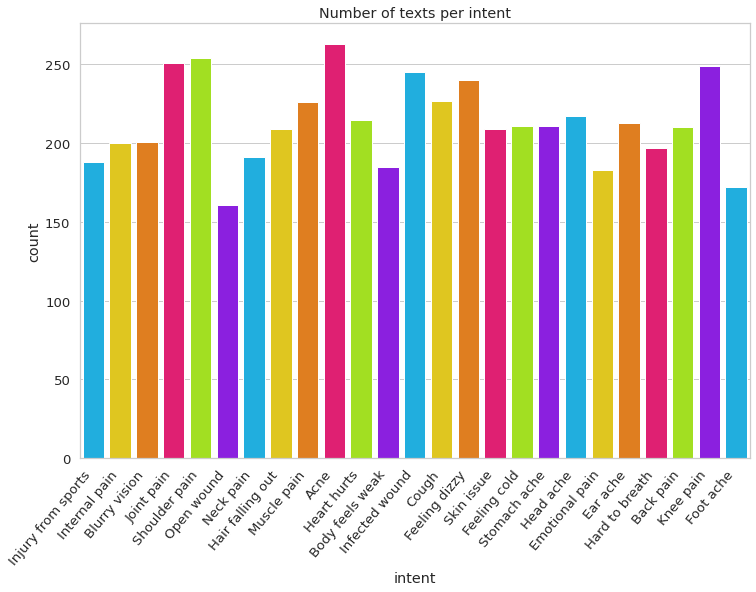

In [11]:

chart = sns.countplot(trainlabels, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=50, horizontalalignment='right');

In [12]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
import numpy as np
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text)     
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

vec_preprocess_text = np.vectorize(clean_text)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:

df_train = traindf.reset_index(drop=True)
df_train['text'] = df_train['text'].str.replace('\d+', '')
processed_train = vec_preprocess_text(traindf.text.values)

df_train = validdf.reset_index(drop=True)
df_train['text'] = df_train['text'].str.replace('\d+', '')
processed_val = vec_preprocess_text(validdf.text.values)

df_test = testdf.reset_index(drop=True)
df_test['text'] = df_test['text'].str.replace('\d+', '')
processed_test = vec_preprocess_text(testdf.text.values)



In [15]:
MODEL_NAME = 'bert-base-cased'
MAX_LEN = 100

EPOCHS = 3

In [16]:
from transformers import BertTokenizer, TFBertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [17]:
# Preprocessing of texts according to roberta

def get_masks(text, max_length):
    """Mask for padding"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))

vec_get_masks = np.vectorize(get_masks, signature = '(),()->(n)')

def get_segments(text, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]
    
    segments = []
    current_segment_id = 0
    with_tags = ["[CLS]"] + tokens + ["[SEP]"]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))

vec_get_segments = np.vectorize(get_segments, signature = '(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens = tokenizer.tokenize(text)
    tokens = ["[CLS]"] + tokens + ["[SEP]"]
    length = len(tokens)
    if length > max_length:
        tokens = tokens[:max_length]

    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids

vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')


def prepare(text_array, tokenizer, max_length = 100):
    
    ids = vec_get_ids(text_array, 
                      tokenizer, 
                      max_length).squeeze()
    masks = vec_get_masks(text_array,
                      max_length).squeeze()
    segments = vec_get_segments(text_array,
                      max_length).squeeze()

    return ids, segments, masks

In [18]:
ids_train, segments_train, masks_train = prepare(processed_train,
                                                 tokenizer,
                                                 100)

ids_val, segments_val, masks_val = prepare(processed_val,
                                                 tokenizer,
                                                 100)


ids_test, segments_test, masks_test = prepare(processed_test, 
                                               tokenizer,
                                               100)

In [19]:
import tensorflow as tf


input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
segment_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32,name="segment_ids")
roberta_model = TFBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=25)

x = roberta_model([input_word_ids,input_mask,segment_ids])
x = x[0]
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
output = tf.keras.layers.Dense(25, activation='softmax')(x)
model = tf.keras.Model(inputs=[input_word_ids,input_mask,segment_ids], outputs=[output])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf_bert_for_sequence_classifica TFSequenceClassifier 108329497   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

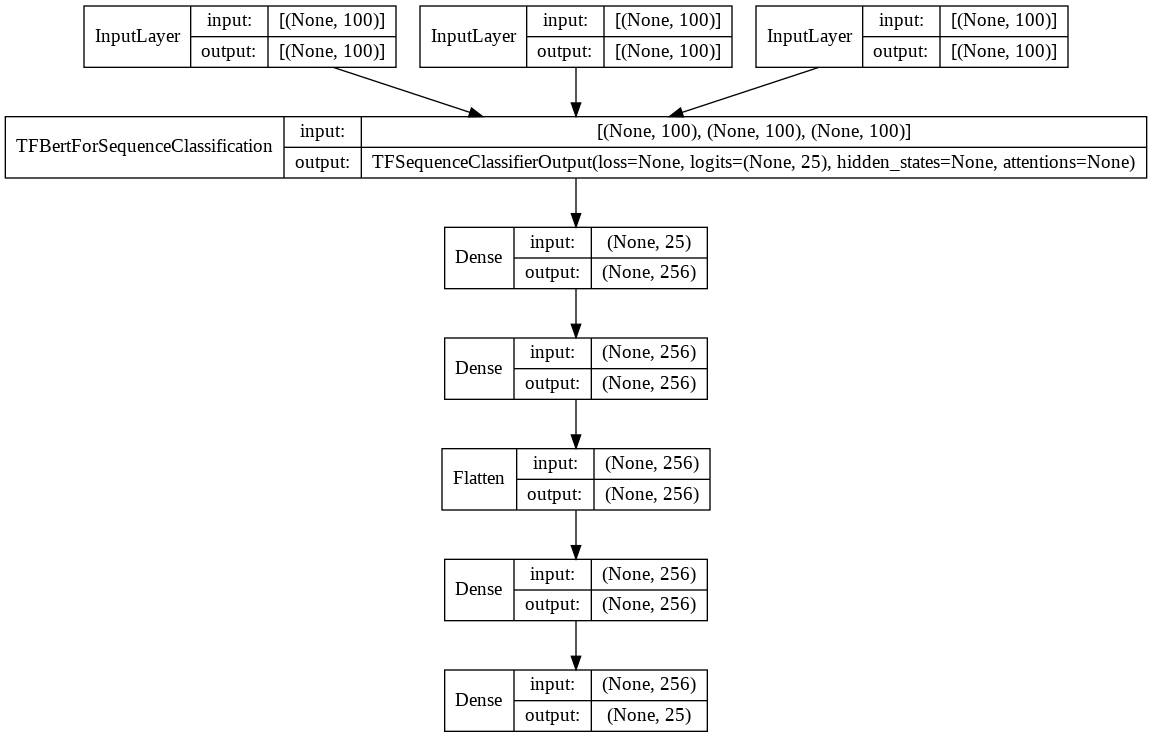

In [21]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None
)

In [22]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(traindf.intent)
traindf['intent'] = le.transform(traindf.intent)

le.fit(validdf.intent)
validdf['intent'] = le.transform(validdf.intent)

le.fit(testdf.intent)
testdf['intent'] = le.transform(testdf.intent)

In [23]:
traindf.intent = traindf.intent.astype(float)
validdf.intent = validdf.intent.astype(float)
testdf.intent = testdf.intent.astype(float)

In [24]:
history1 = model.fit([ids_train, masks_train, segments_train], 
          traindf.intent, validation_data =([ids_val, masks_val, segments_val], validdf.intent),
          epochs = 3,
          batch_size = 16)
          

Epoch 1/3
333/333 [==============================] - 135s 379ms/step - loss: 3.1082 - accuracy: 0.1064 - val_loss: 2.7824 - val_accuracy: 0.2590
Epoch 2/3
333/333 [==============================] - 126s 378ms/step - loss: 2.1542 - accuracy: 0.5312 - val_loss: 1.3341 - val_accuracy: 0.8086
Epoch 3/3
333/333 [==============================] - 126s 380ms/step - loss: 0.8582 - accuracy: 0.9304 - val_loss: 0.3899 - val_accuracy: 0.9902


In [25]:
# Model Evaluation 

model.evaluate([ids_test, masks_test, segments_test], testdf.intent)


84/84 [==============================] - 18s 218ms/step - loss: 0.3956 - accuracy: 0.9887


[0.39561471343040466, 0.9887387156486511]

In [26]:
y_pred = model.predict([ids_test, masks_test, segments_test])

y_pred_bool = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report

print(classification_report(y_pred_bool, testdf.intent))


              precision    recall  f1-score   support

           0       1.00      0.98      0.99       135
           1       1.00      1.00      1.00       107
           2       1.00      1.00      1.00        94
           3       0.99      1.00      1.00       103
           4       1.00      1.00      1.00       114
           5       1.00      1.00      1.00       108
           6       0.97      0.99      0.98        84
           7       1.00      1.00      1.00       105
           8       1.00      1.00      1.00       116
           9       0.99      1.00      0.99        93
          10       1.00      0.99      1.00       114
          11       1.00      1.00      1.00        99
          12       1.00      1.00      1.00        97
          13       0.97      0.97      0.97       102
          14       1.00      0.99      1.00       114
          15       1.00      1.00      1.00        97
          16       0.81      1.00      0.90        81
          17       0.99    

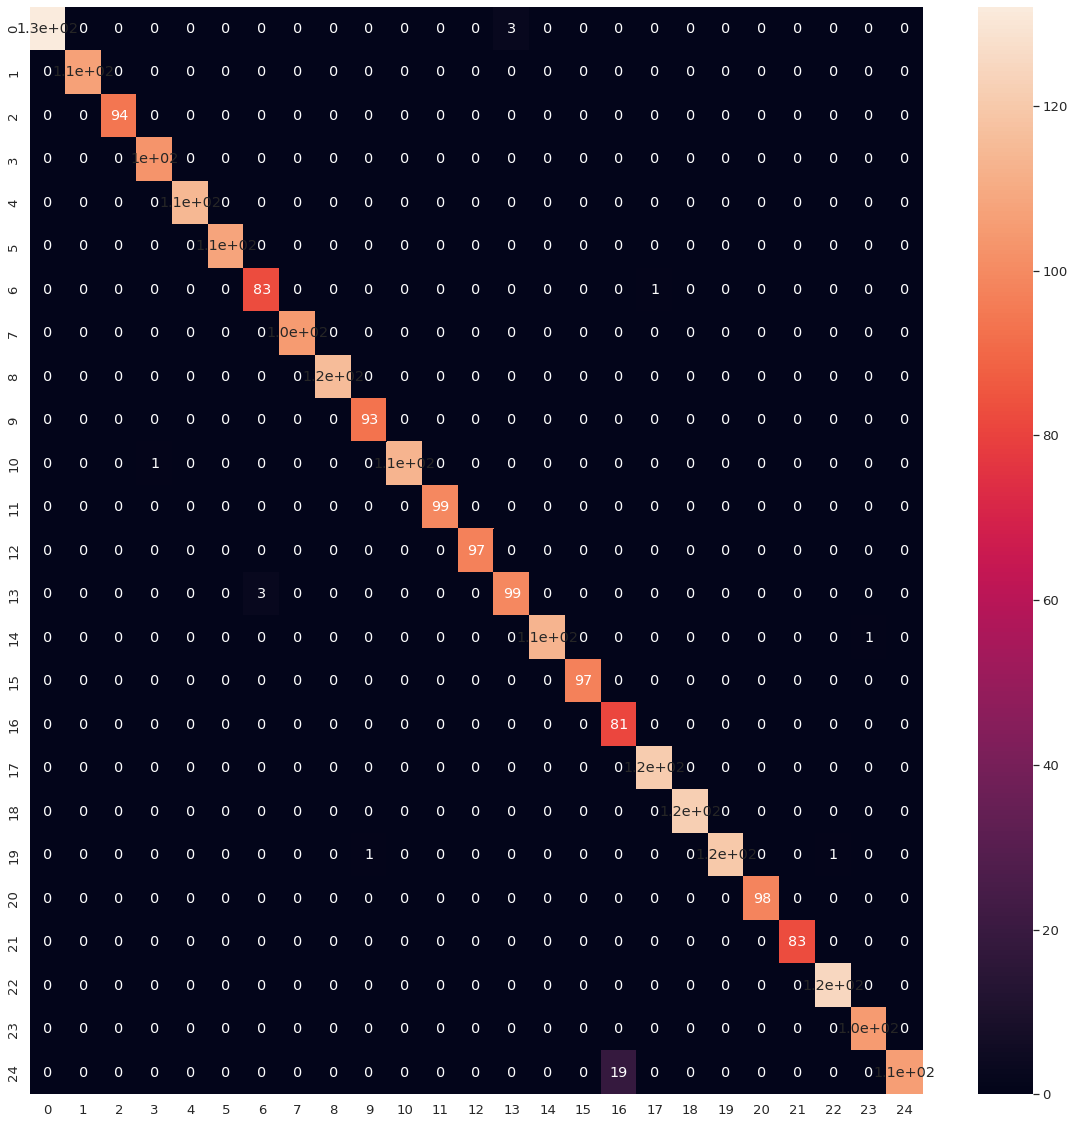

In [27]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred_bool, testdf.intent)

import matplotlib.pyplot as plt
import seaborn as sn 

plt.figure(figsize = (20,20))
sn.heatmap(cm, annot=True)